## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import os.path
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    #if fname[-6:-4] in('n1', 'n4', 'n5'):
    #    patternSize = (9,5)
    #else:
    patternSize = (9,6)
    ret, corners = cv2.findChessboardCorners(gray, patternSize, None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, patternSize, corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(100)
    else:
        print("No corners found in image:", fname)

cv2.destroyAllWindows()
print(len(imgpoints), "images found with ChessboardCorners")

# Do camera calibration given object points and image points
if imgpoints:
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

No corners found in image: camera_cal\calibration1.jpg
No corners found in image: camera_cal\calibration4.jpg
No corners found in image: camera_cal\calibration5.jpg
17 images found with ChessboardCorners


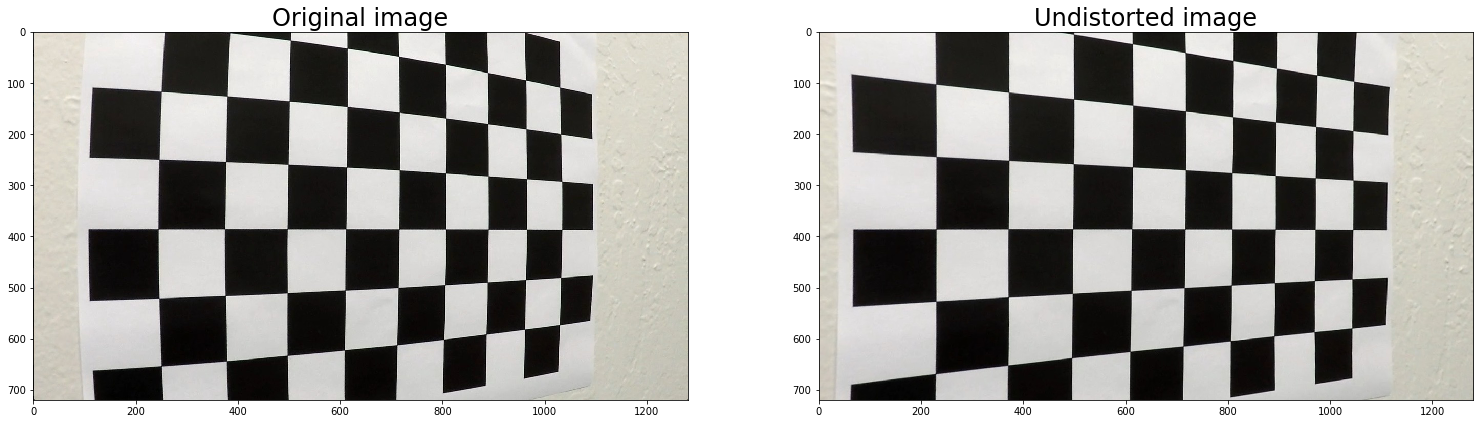

In [2]:
%matplotlib inline

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
    
# Undistort image
image = mpimg.imread('camera_cal/calibration5.jpg')
undist = undistort(image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original image', fontsize=24)
ax1.imshow(image)
ax2.set_title('Undistorted image', fontsize=24)
ax2.imshow(undist)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

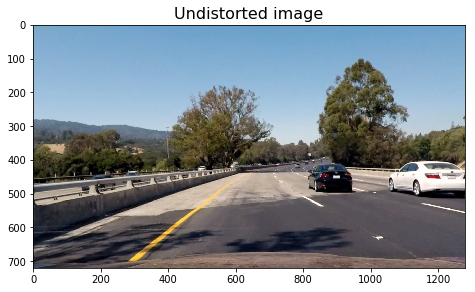

In [3]:
# Undistort image
image = mpimg.imread('test_images/test4.jpg')
undist = undistort(image)
plt.title('Undistorted image', fontsize=16)
plt.imshow(undist)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply Sobel Operator to Find Lane Lines

In [4]:
def sobel(monochrome, ksize_x=3, ksize_y=3, thresh_x=(0, 255), thresh_y=(0, 255), 
          thresh_mag=(0, 255), thresh_dir=(0, np.pi/2)):
    " Calculate directional gradients, magnitude and direction "
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_x = np.absolute(cv2.Sobel(monochrome, cv2.CV_64F, 1, 0, ksize=ksize_x))
    abs_y = np.absolute(cv2.Sobel(monochrome, cv2.CV_64F, 0, 1, ksize=ksize_y))
    # Calculate the gradient magnitude
    magnitude = np.sqrt(abs_x**2 + abs_x**2)
    # Take the absolute value of the gradient direction
    abs_dir = np.arctan2(abs_y, abs_x)
    # Rescale back to 8 bit integer
    scaled_x = np.uint8(255 * abs_x / np.max(abs_x))
    scaled_y = np.uint8(255 * abs_y / np.max(abs_y))
    scaled_mag = np.uint8(255 * magnitude / np.max(magnitude))
    # Create a copy ...
    binary_x = np.zeros_like(scaled_x)
    binary_y = np.zeros_like(scaled_y)
    binary_mag = np.zeros_like(scaled_mag)
    binary_dir = np.zeros_like(scaled_mag) # abs_dir is float!
    # ... and apply the threshold
    binary_x[(scaled_x >= thresh_x[0]) & (scaled_x <= thresh_x[1])] = 1
    binary_y[(scaled_y >= thresh_y[0]) & (scaled_y <= thresh_y[1])] = 1
    binary_mag[(scaled_mag >= thresh_mag[0]) & (scaled_mag <= thresh_mag[1])] = 1
    binary_dir[(abs_dir >= thresh_dir[0]) & (abs_dir <= thresh_dir[1])] = 1
    return binary_x, binary_y, binary_mag, binary_dir

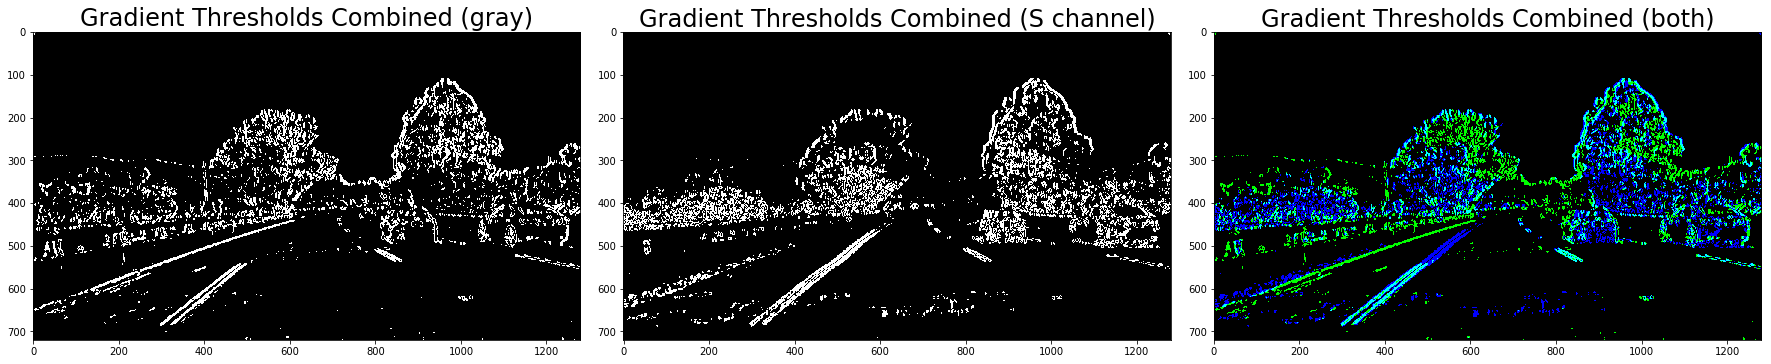

In [5]:
# Choose Sobel kernel sizes
# Choose a larger odd number to smooth gradient measurements
KSIZE_X = 15 
KSIZE_Y = 15
#ksize_mag = 15
#ksize_dir = 15
# Choose Sobel thresholds
THRESH_X = (20, 100)
THRESH_Y = (20, 100)
THRESH_MAG = (30, 100)
THRESH_DIR = (0.7, 1.0) #1.3

def combined_sobel_threshold(monochrome):
    binary_x, binary_y, binary_mag, binary_dir = \
            sobel(monochrome, KSIZE_X, KSIZE_Y, THRESH_X, 
                  THRESH_Y, THRESH_MAG, THRESH_DIR)

    combined = np.zeros_like(binary_x)
    combined[((binary_x == 1) & (binary_y == 1)) | 
             ((binary_mag == 1) & (binary_dir == 1)) | 
             ((binary_x == 1) & (binary_mag == 1)) | 
             ((binary_y == 1) & (binary_dir == 1))] = 1
    return combined


# Read in an image
image = mpimg.imread('test_images/test4.jpg')
#image = mpimg.imread('../signs_vehicles_xygrad.png')
# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Convert to HLS color space and separate the S channel
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
combined1 = combined_sobel_threshold(gray)
combined2 = combined_sobel_threshold(s_channel)
color_binary = np.dstack(( np.zeros_like(combined1), combined1, combined2)) * 255

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined1, cmap='gray')
ax1.set_title('Gradient Thresholds Combined (gray)', fontsize=24)
ax2.imshow(combined2, cmap='gray')
ax2.set_title('Gradient Thresholds Combined (S channel)', fontsize=24)
ax3.imshow(color_binary)
ax3.set_title('Gradient Thresholds Combined (both)', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Convert to HLS and Apply Color Thresholds

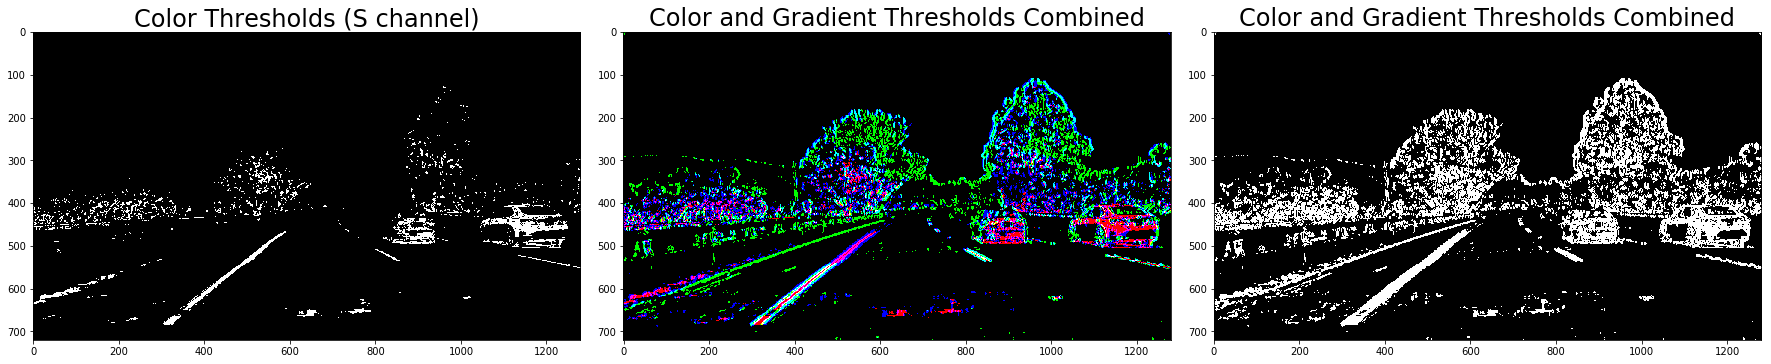

In [6]:
# Threshold color channel
THRESH_S = (150, 255)

def combined_sobel_color_threshold(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Convert to HLS color space and separate the S channel
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    combined1 = combined_sobel_threshold(gray)
    combined2 = combined_sobel_threshold(s_channel)
    combined = np.zeros_like(combined1)
    combined[((combined1 == 1) | (combined2 == 1)) |
             (s_channel >= THRESH_S[0]) & (s_channel <= THRESH_S[1])] = 1
    return combined


# Convert to HLS color space and separate the S channel
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= THRESH_S[0]) & (s_channel <= THRESH_S[1])] = 1
color_binary[:,:,0] = s_binary * 255 
combined3 = combined_sobel_color_threshold(image)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(s_binary, cmap='gray')
ax1.set_title('Color Thresholds (S channel)', fontsize=24)
ax2.imshow(color_binary)
ax2.set_title('Color and Gradient Thresholds Combined', fontsize=24)
ax3.imshow(combined3, cmap='gray')
ax3.set_title('Color and Gradient Thresholds Combined', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Parameter Tuning

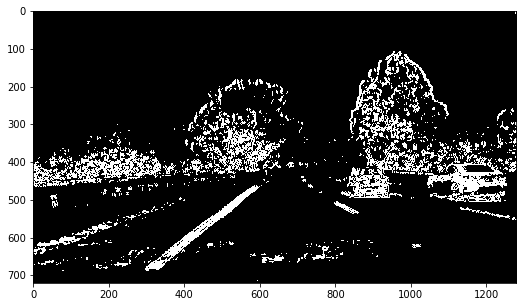

In [7]:
from ipywidgets import interact

def combined_sobel_threshold_tune(ksize_x, ksize_y, min_x, max_x, min_y, max_y, 
                                  min_mag, max_mag, min_dir, max_dir,
                                  color_min, color_max):
    binary_x, binary_y, binary_mag, binary_dir = \
            sobel(monochrome, ksize_x, ksize_y, (min_x, max_x), 
                  (min_y, max_y), (min_mag, max_mag), (min_dir, max_dir))

    combined = np.zeros_like(binary_x)
    combined[((binary_x == 1) & (binary_y == 1)) | 
             ((binary_mag == 1) & (binary_dir == 1)) | 
             ((binary_x == 1) & (binary_mag == 1)) | 
             ((binary_y == 1) & (binary_dir == 1))|
             (monochrome >= color_min) & (monochrome <= color_max)] = 1
    plt.figure(figsize=(10,5))
    plt.imshow(combined, cmap="gray")
    
monochrome = s_channel
interact(combined_sobel_threshold_tune, ksize_x=(3,15,2), ksize_y=(3,15,2), 
         min_x=(0,200,5), max_x=(50,255,5), min_y=(0,200,5), max_y=(50,255,5), 
         min_mag=(0,200,5), max_mag=(50,255,5), min_dir=(0,1.4,0.1), max_dir=(0.2,1.6,0.1), 
         color_min=(0,200,5), color_max=(50,255,5))

## Perspective Transform

In [8]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

(1280, 720)
[[  586.           455.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  699.           455.        ]]


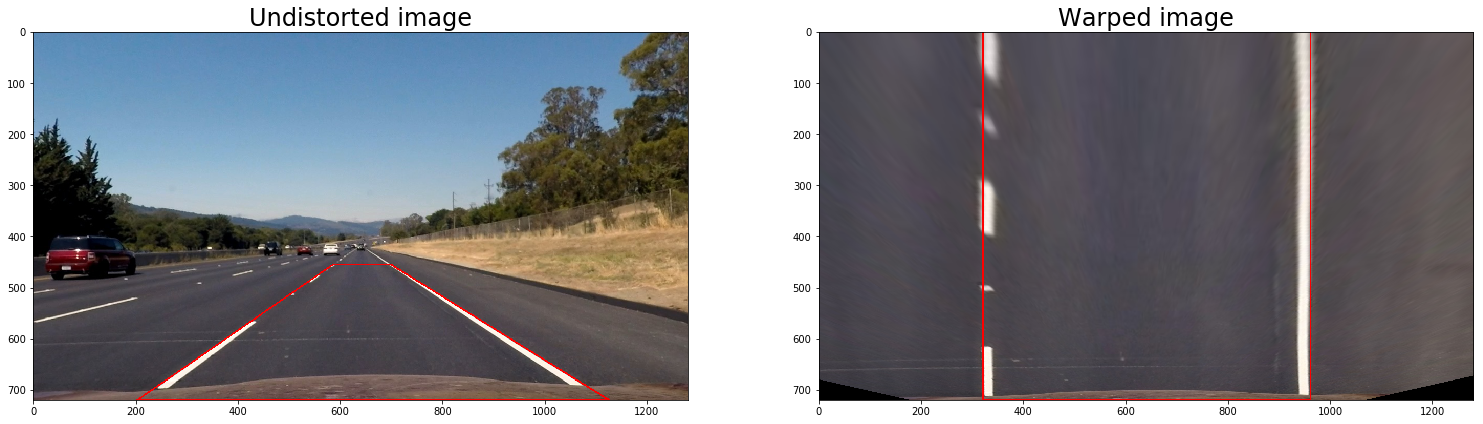

In [9]:
# Read in image with straight lane lines
straight = mpimg.imread('test_images/straight_lines2.jpg')
img_size = straight.shape[1::-1]
print(img_size)

# Undistort image
undist = undistort(straight)
#undist = straight

# define vertices for warping (x, y)!
max_x = img_size[0] - 1
max_y = img_size[1] - 1
mid_x = img_size[0] // 2
offset = 300
offset_x = 203
offset_y = 455
#src_verts = np.array([[offset_x+2,max_y],[mid_x-54,offset_y],[mid_x+53,offset_y],[max_x-offset_x-1,max_y]], 
#                     dtype=np.float32)
#dst_verts = np.array([[offset,max_y],[offset,0],[max_x-offset,0],[max_x-offset,max_y]], dtype=np.float32)
src_verts = np.float32(
    [[(img_size[0] / 2) - 54, img_size[1] / 2 + 95],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 59), img_size[1] / 2 + 95]])
dst_verts = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
M = cv2.getPerspectiveTransform(src_verts, dst_verts)
Minv = cv2.getPerspectiveTransform(dst_verts, src_verts)
print(src_verts)
def warp(undist):
    " warp image to top-down view "
    return cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

src_lines = [[(*p1, *p2) for p1, p2 in zip(src_verts, np.roll(src_verts, -1, axis=0))]]
src_img = undist.copy()
draw_lines(src_img, src_lines, color=[255, 0, 0], thickness=2)
warped = warp(undist)
dst_lines = [[(*p1, *p2) for p1, p2 in zip(dst_verts, np.roll(dst_verts, -1, axis=0))]]
draw_lines(warped, dst_lines, color=[255, 0, 0], thickness=2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image', fontsize=24)
ax1.imshow(src_img)
ax2.set_title('Warped image', fontsize=24)
ax2.imshow(warped)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Locate the Lane Lines and Fit a Polynomial

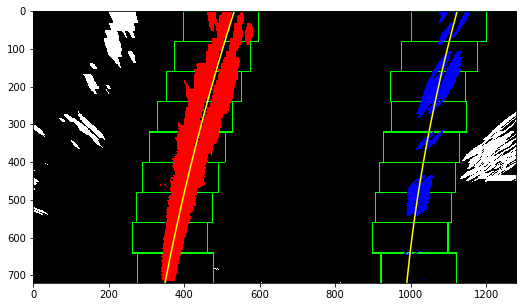

In [10]:
def get_initial_lane_fit(binary_warped, plot=False, return_img=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if plot or return_img:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        if plot:
            plt.figure(figsize=(10,5))
            plt.imshow(out_img)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)

        if return_img:
            return left_fit, right_fit, out_img
            
    return left_fit, right_fit


image = mpimg.imread('test_images/test6.jpg')
undist = undistort(image)
filtered = combined_sobel_color_threshold(undist)
binary_warped = warp(filtered)
left_fit, right_fit = get_initial_lane_fit(binary_warped, plot=True)

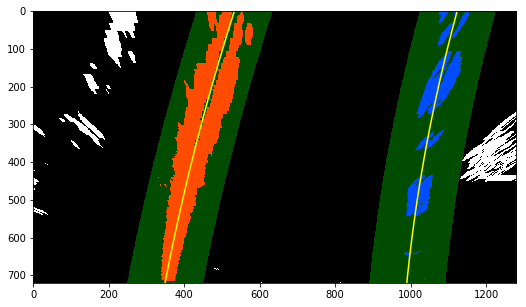

In [11]:
def get_continue_lane_fit(binary_warped, left_fit, right_fit, plot=False, return_img=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if plot or return_img:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        if plot:
            plt.figure(figsize=(10,5))
            plt.imshow(result)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
        
        if return_img:
            return left_fit, right_fit, result
            
    return left_fit, right_fit

left_fit, right_fit = get_continue_lane_fit(binary_warped, left_fit, right_fit, plot=True)

## Sliding Window Search using Convolutions

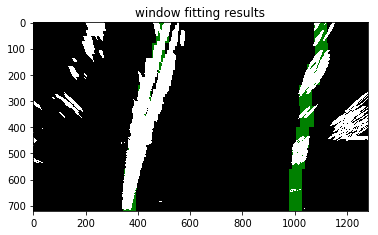

In [12]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

image = mpimg.imread('test_images/test6.jpg')
undist = undistort(image)
filtered = combined_sobel_color_threshold(undist)
binary_warped = warp(filtered)
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(binary_warped)
    r_points = np.zeros_like(binary_warped)

    # Go through each level and draw the windows     
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((binary_warped, binary_warped, binary_warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

## Measuring Curvature

In [13]:
def curvature(curve_fit, y_eval=719):
    return ((1 + (2*curve_fit[0]*y_eval + curve_fit[1])**2)**1.5) / np.absolute(2*curve_fit[0])

y_eval = img_size[1] - 1
print(curvature(left_fit, y_eval), curvature(right_fit, y_eval))

6089.12085768 4249.96090809


In [14]:
# Define conversions in x and y from pixels space to meters
XM_PER_PIX = 3.7/640 # meters per pixel in x dimension
YM_PER_PIX = 30./720 # meters per pixel in y dimension
PIX_TO_M_FIT = XM_PER_PIX / np.array([YM_PER_PIX**2, YM_PER_PIX, 1.])
print(XM_PER_PIX)
print(YM_PER_PIX)
print(PIX_TO_M_FIT)

print(curvature(left_fit*PIX_TO_M_FIT, y_eval*YM_PER_PIX), 
      curvature(right_fit*PIX_TO_M_FIT, y_eval*YM_PER_PIX))

0.00578125
0.041666666666666664
[ 3.33        0.13875     0.00578125]
1733.23053899 1257.88725539


## Plot Lane

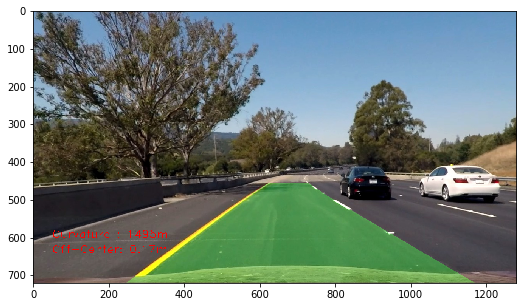

In [15]:
def plot_lane(img, left_fit, right_fit, plot=False):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_size[1]-1, img_size[1] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    offcenter = ((right_fitx[-1] + left_fitx[-1] - img_size[0]) / 2) * XM_PER_PIX
    radius = (curvature(left_fit*PIX_TO_M_FIT, y_eval*YM_PER_PIX) + 
              curvature(right_fit*PIX_TO_M_FIT, y_eval*YM_PER_PIX)) / 2

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[0], img_size[1])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    cv2.putText(result, "Curvature : {:4}m".format(int(radius)), (50, 600), cv2.FONT_HERSHEY_DUPLEX, 1, 255)
    cv2.putText(result, "Off-Center: {:4.2f}m".format(float(offcenter)), (50, 640), cv2.FONT_HERSHEY_DUPLEX, 1, 255)
    if plot:
        plt.figure(figsize=(10,5))
        plt.imshow(result)
    return result

result = plot_lane(undist, left_fit, right_fit, plot=True)

## Create Pipeline

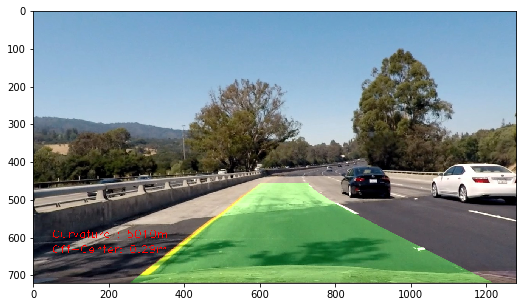

In [16]:
def process_image(image):
    img_size = image.shape[1::-1]
    # Undistort image
    undist = undistort(image)
    # Apply gradient and color filters
    filtered = combined_sobel_color_threshold(undist)
    # Apply perspective transform
    binary_warped = warp(filtered)
    # Calculate first lane fit
    left_fit, right_fit = get_initial_lane_fit(binary_warped)
    curve = (curvature(left_fit*PIX_TO_M_FIT, y_eval*YM_PER_PIX) + 
             curvature(right_fit*PIX_TO_M_FIT, y_eval*YM_PER_PIX)) / 2
    return plot_lane(undist, left_fit, right_fit, curve)


#image = mpimg.imread('test_images/straight_lines1.jpg')
image = mpimg.imread('test_images/test4.jpg')
result = process_image(image)
plt.imshow(result)

## Create Class Line to Hold Data and Methods of Line Detection

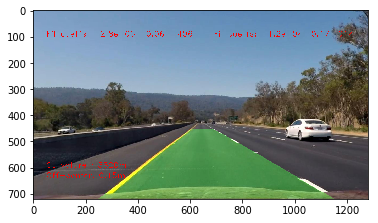

In [17]:
from collections import deque
import scipy.stats as scistats
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, Minv=Minv, last_n=5, n_windows=9, margin=100, minpix=50, 
                 maxpix_percent=0.8, max_diff=0.2):
        # inverse perspective matrix
        self.Minv = Minv
        # number of recent values to keep (n)
        self.last_n = last_n
        # Choose the number of sliding windows
        self.n_windows = n_windows
        # height of windows for lane fit
        self.window_height = None
        # Set the width of the windows +/- margin
        self.margin = margin
        # Set minimum number of pixels found to recenter window
        self.minpix = minpix
        # Set maximum percentage of pixels found to recenter window
        self.maxpix_percent = maxpix_percent
        # Set maximum number of pixels found to recenter window
        self.maxpix = None
        # was the line detected in the last iteration?
        self.detected = False
        # y values for the fits
        self.yfitted = None
        # x values for the most recent fit
        self.current_xfitted = None
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=last_n) 
        #average x values of the fitted line over the last n iterations
        self.best_xfitted = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # y position for evaluation of curvature
        self.y_eval = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # lane width
        self.lane_width = None
        #distance in pixels of vehicle center from the line
        self.off_center_base = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits (in percent)
        self.diffs = np.array([0,0,0], dtype='float') 
        # max difference in fit coefficients between last and new fits
        self.max_diff = max_diff
        #x values for previously detected line pixels (most recent left) - centered
        self.recent_x = deque(maxlen=last_n)   
        #y values for previously detected line pixels (most recent left)
        self.recent_y = deque(maxlen=last_n) 
        # image size (x, y)
        self.img_size = None
        # binary warped image
        self.binary_warped = None

    def process_image(self, image, return_warped=False):
        # undistort image
        undist = undistort(image)
        # apply gradient and color filters
        filtered = combined_sobel_color_threshold(undist)
        # apply perspective transform
        binary_warped = warp(filtered)
        #binary_warped = cv2.morphologyEx(binary_warped, op=cv2.MORPH_OPEN, kernel=np.ones((5,5),np.uint8))
        # calculate first lane fit
        if not self.detected or len(self.recent_xfitted) < self.last_n:
            if not self.img_size:
                self.img_size = image.shape[1::-1]
                # Set y position for evaluation of curvature
                self.y_eval = self.img_size[1] - 1
                # Generate y values for plotting
                self.yfitted = np.linspace(0, self.img_size[1]-1, self.img_size[1])
                # Set height of windows for lane fit
                self.window_height = np.int(self.img_size[1]/self.n_windows)
                window_size = self.window_height * self.margin * 2
                self.maxpix = int(window_size * self.maxpix_percent)
            # Find lane lines pixels and fit line
            result = self._initial_lane_fit(binary_warped, return_img=return_warped)
            self.detected = True
        else:
            # Find lane lines pixels and fit line
            result = self._continue_lane_fit(binary_warped, return_img=return_warped)
        sane_result = self._sanity_check()
        if return_warped:
            return result
        if not sane_result:
            self.detected = False
            self.recent_xfitted = deque(maxlen=self.last_n) 
        return self._plot_lane(undist)

    def _calculate_best_fit(self):
        # Extract left and right line pixel positions from recent fits
        leftx = []
        lefty = []
        rightx = []
        righty = []
        for lx, rx in self.recent_xfitted:
            leftx.append(lx)
            lefty.append(self.yfitted)
            rightx.append(rx)
            righty.append(self.yfitted)
        # Concatenate the arrays of x values
        leftx = np.concatenate(leftx) + self.off_center_base
        lefty = np.concatenate(lefty)
        rightx = np.concatenate(rightx) + self.off_center_base
        righty = np.concatenate(righty)
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        self.best_fit = left_fit, right_fit
        # Generate x values for best fit and plotting
        left_fitx = left_fit[0]*self.yfitted**2 + left_fit[1]*self.yfitted + left_fit[2]
        right_fitx = right_fit[0]*self.yfitted**2 + right_fit[1]*self.yfitted + right_fit[2]
        self.best_xfitted = (left_fitx, right_fitx)
    
    def _calculate_curvature(self, current_fit=False):
        left_fit, right_fit = self.current_fit if current_fit else self.best_fit
        self.radius_of_curvature = (curvature(left_fit*PIX_TO_M_FIT, self.y_eval*YM_PER_PIX) + 
                                    curvature(right_fit*PIX_TO_M_FIT, self.y_eval*YM_PER_PIX)) / 2
        #print(self.radius_of_curvature)

    def _calculate_offcenter(self, current_fit=False):
        left_fitx, right_fitx = self.current_xfitted if current_fit else self.best_xfitted
        self.lane_width = (right_fitx[self.y_eval] - left_fitx[self.y_eval]) * XM_PER_PIX
        self.line_base_pos = round(((right_fitx[self.y_eval] + left_fitx[self.y_eval]
                                   - self.img_size[0]) / 2) * XM_PER_PIX, 2)
        #print(self.lane_width)
        #print(self.line_base_pos)

    def _initial_lane_fit(self, binary_warped, return_img=False):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[self.img_size[1]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_max = np.max(histogram[:midpoint])
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_max = np.max(histogram[midpoint:])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Check if lane lines are dashed and can be augmented by opposite line
        dashed_left = leftx_max < 0.8 * rightx_max
        dashed_right = rightx_max < 0.8 * leftx_max
        # calculate distance from vehicle center to lane center at base position
        off_center_base = int((rightx_base + leftx_base - self.img_size[0]) / 2)
        if return_img:
            # Create an output image to draw on and  visualize the result
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        # Step through the windows one by one
        for window in range(self.n_windows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = self.img_size[1] - (window+1)*self.window_height
            win_y_high = self.img_size[1] - window*self.window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin
            if return_img:
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                (0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if self.maxpix > len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if self.maxpix > len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        #x values for previously detected line pixels (most recent left)
        self.recent_x.appendleft((leftx - off_center_base, rightx - off_center_base))
        #y values forpreviously detected line pixels (most recent left)
        self.recent_y.appendleft((lefty, righty))
        # Append with some data from previous iterations
        leftx_all = []
        lefty_all = []
        rightx_all = []
        righty_all = []
        factor = 1.
        for (lx, rx), (ly, ry) in zip(self.recent_x, self.recent_y):
            left_keep_n = int(factor * len(lx)) 
            left_inds = np.random.choice(range(len(lx)), left_keep_n, replace=False)
            leftx_all.append(lx[left_inds])
            lefty_all.append(ly[left_inds])
            right_keep_n = int(factor * len(rx)) 
            right_inds = np.random.choice(range(len(rx)), right_keep_n, replace=False)
            rightx_all.append(rx[right_inds])
            righty_all.append(ry[right_inds])
            # keep 80% of the lane pixels from previous iteration
            factor *= 0.8
            break
        leftx_all = np.concatenate(leftx_all) + off_center_base
        lefty_all = np.concatenate(lefty_all)
        rightx_all = np.concatenate(rightx_all) + off_center_base
        righty_all = np.concatenate(righty_all) 
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty_all, leftx_all, 2)
        right_fit = np.polyfit(righty_all, rightx_all, 2)
        # Generate x values for best fit and plotting
        left_fitx = left_fit[0]*self.yfitted**2 + left_fit[1]*self.yfitted + left_fit[2]
        right_fitx = right_fit[0]*self.yfitted**2 + right_fit[1]*self.yfitted + right_fit[2]
        lane_widths = right_fitx - left_fitx
        #print(lane_widths.min())
        #print(lane_widths.max())
        avg_lane_width = lane_widths.sum() / self.img_size[1]
        #print(avg_lane_width)
        #print(scistats.mode(np.round(lane_widths, 0).astype(np.int)))
        if False and dashed_left:
            left_fitx1 = right_fitx - avg_lane_width
            leftx = np.concatenate((left_fitx, left_fitx1))
            lefty = np.concatenate((self.yfitted, self.yfitted))
            left_fit = np.polyfit(lefty, leftx, 2)
            left_fitx = left_fit[0]*self.yfitted**2 + left_fit[1]*self.yfitted + left_fit[2]
        elif False and dashed_right:
            right_fitx1 = left_fitx + avg_lane_width
            rightx = np.concatenate((right_fitx, right_fitx1))
            righty = np.concatenate((self.yfitted, self.yfitted))
            right_fit = np.polyfit(righty, rightx, 2)
            right_fitx = right_fit[0]*self.yfitted**2 + right_fit[1]*self.yfitted + right_fit[2]
        self.off_center_base = off_center_base #int((right_fitx[-1] + left_fitx[-1] - self.img_size[0]) / 2)
        self.current_fit = (left_fit, right_fit)
        self.current_xfitted = (left_fitx, right_fitx)
        if return_img:
            left_in = 0 <= leftx_all
            right_in = rightx_all < self.img_size[0]
            out_img[lefty_all[left_in], leftx_all[left_in]] = [255, 0, 255]
            out_img[righty_all[right_in], rightx_all[right_in]] = [0, 255, 255]
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            fit_points = np.array([np.array([left_fitx, self.yfitted]).T,
                                   np.array([right_fitx, self.yfitted]).T], dtype=np.int32)
            cv2.polylines(out_img, fit_points, isClosed=False, color=(255,255,0), 
                          thickness=2, lineType=cv2.LINE_AA)
            return out_img

    def _continue_lane_fit(self, binary_warped, return_img=False):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        histogram = np.sum(binary_warped[self.img_size[1]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # calculate distance from vehicle center to lane center at base position
        off_center_base = int((rightx_base + leftx_base - self.img_size[0]) / 2)
        left_fit, right_fit = self.best_fit
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - self.margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + self.margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - self.margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + self.margin)))  
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Append with some data from previous iterations
        leftx_all = [leftx]
        lefty_all = [lefty]
        rightx_all = [rightx]
        righty_all = [righty]
        factor = 1.
        for (lx, rx), (ly, ry) in []:#zip(self.recent_x, self.recent_y):
            # keep 80% of the lane pixels from previous iteration
            factor *= 0.8
            left_keep_n = int(factor * len(lx)) 
            left_inds = np.random.choice(range(len(lx)), left_keep_n, replace=False)
            leftx_all.append(lx[left_inds] + off_center_base)
            lefty_all.append(ly[left_inds])
            right_keep_n = int(factor * len(rx)) 
            right_inds = np.random.choice(range(len(rx)), right_keep_n, replace=False)
            rightx_all.append(rx[right_inds] + off_center_base)
            righty_all.append(ry[right_inds])
        leftx_all = np.concatenate(leftx_all)
        lefty_all = np.concatenate(lefty_all)
        rightx_all = np.concatenate(rightx_all)
        righty_all = np.concatenate(righty_all)
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty_all, leftx_all, 2)
        right_fit = np.polyfit(righty_all, rightx_all, 2)
        self.off_center_base = off_center_base #int((right_fitx[-1] + left_fitx[-1] - self.img_size[0]) / 2)
        #x values for detected line pixels
        self.recent_x.appendleft((leftx, rightx))
        #y values for detected line pixels
        self.recent_y.appendleft((lefty, righty))
        self.current_fit = left_fit, right_fit
        self.diffs = ((left_fit - self.best_fit[0]) / self.best_fit[0],
                      (right_fit - self.best_fit[1]) / self.best_fit[1])
        #print(self.diffs[0])
        #print(self.diffs[1])
        # Generate x values for best fit and plotting
        left_fitx = left_fit[0]*self.yfitted**2 + left_fit[1]*self.yfitted + left_fit[2]
        right_fitx = right_fit[0]*self.yfitted**2 + right_fit[1]*self.yfitted + right_fit[2]
        self.current_xfitted = (left_fitx, right_fitx)
        if return_img:
            # Create an image to draw on and an image to show the selection window
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            left_in = 0 <= leftx_all
            right_in = rightx_all < self.img_size[0]
            out_img[lefty_all[left_in], leftx_all[left_in]] = [255, 0, 255]
            out_img[righty_all[right_in], rightx_all[right_in]] = [0, 255, 255]
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-self.margin, self.yfitted]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+self.margin, 
                                          self.yfitted])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-self.margin, self.yfitted]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+self.margin, 
                                          self.yfitted])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))
            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            fit_points = np.array([np.array([left_fitx, self.yfitted]).T,
                                   np.array([right_fitx, self.yfitted]).T], dtype=np.int32)
            cv2.polylines(result, fit_points, isClosed=False, color=(255,255,0), 
                          thickness=2, lineType=cv2.LINE_AA)
            return result
    
    def _plot_lane(self, undist, current_fit=False):
        # Create an image to draw the lines on
        color_warp = np.zeros_like(undist).astype(np.uint8)
        # Get x values of fitted lines
        left_fitx, right_fitx = self.current_xfitted if current_fit else self.best_xfitted
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, self.yfitted]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, self.yfitted])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, self.img_size) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        cv2.putText(result, "Fit coeffs: {:8.1e} {:5.2f} {:5.0f}".format(*self.current_fit[0]), 
                    (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, 255)
        cv2.putText(result, "Fit coeffs: {:8.1e} {:5.2f} {:4.0f}".format(*self.current_fit[1]), 
                    (690, 100), cv2.FONT_HERSHEY_DUPLEX, 1, 255)
        cv2.putText(result, "Curvature : {:4}m".format(int(self.radius_of_curvature)), 
                    (50, 600), cv2.FONT_HERSHEY_DUPLEX, 1, 255)
        if not self.line_base_pos is None:
            cv2.putText(result, "Off-center: {:4.2f}m".format(self.line_base_pos), 
                        (50, 640), cv2.FONT_HERSHEY_DUPLEX, 1, 255)
        return result
        
    def _sanity_check(self):
        sane_result = True
        lane_widths = (self.current_xfitted[1] - self.current_xfitted[0]) * XM_PER_PIX
        self.lane_width_min = lane_widths.min()
        self.lane_width_max = lane_widths.max()
        #print(lane_widths.min())
        #print(lane_widths.max())
        self.avg_lane_width = lane_widths.sum() / self.img_size[1]
        sane_result = ((self.lane_width_min > 2.9) and (self.lane_width_max < 4.5) and
                       (3.3 < self.avg_lane_width < 4.1) and
                       ((self.avg_lane_width - self.lane_width_min) < 0.4) and
                       ((self.lane_width_max - self.avg_lane_width) < 0.4) and
                       ((self.lane_width_max - self.lane_width_min) < 0.8))

        if len(self.recent_xfitted) < self.last_n:
            self.recent_xfitted.appendleft(
                (self.current_xfitted[0] - self.off_center_base,
                 self.current_xfitted[1] - self.off_center_base))
            if self.best_fit is None:
                self.best_fit = self.current_fit
                self.best_xfitted = self.current_xfitted
            else:
                self._calculate_best_fit()
            lane_widths = self.best_xfitted[1] - self.best_xfitted[0]
            #print(lane_widths.min())
            #print(lane_widths.max())
            #print(scistats.mode(np.round(lane_widths, 0).astype(np.int)))
            avg_lane_width = lane_widths.sum() / self.img_size[1]
            #print(avg_lane_width)
            
            self._calculate_curvature()
            self._calculate_offcenter()
            return sane_result
        
        #for diffs in self.diffs:
        #    for diff in diffs:
        #        sane_result = sane_result & (diff < self.max_diff)  

        if sane_result:
            self.recent_xfitted.appendleft(
                (self.current_xfitted[0] - self.off_center_base,
                 self.current_xfitted[1] - self.off_center_base))
            self._calculate_best_fit()
            self._calculate_curvature()
            self._calculate_offcenter()
        return sane_result    
    
        
#image = mpimg.imread('test_images/test5.jpg')
#image = mpimg.imread('test_images/img_22s_0020.jpg')
image = mpimg.imread('test_images/img_15s_0001.jpg')
line = Line()
result = line.process_image(image)
#image = mpimg.imread('test_images/img_22s_0021.jpg')
image = mpimg.imread('test_images/img_15s_0002.jpg')
result = line.process_image(image)
plt.imshow(result)

## Process Video

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
import imageio
img_count = 0
def save_images(img):
    global img_count
    img_count += 1
    imageio.imwrite('test_images/img_22s_{:0=4}.jpg'.format(img_count), img)
    return img    

In [20]:
line = Line()
video_output = 'output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(line.process_image) #NOTE: this function expects color images!!
#video_clip = clip1.fl_image(save_images) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [13:15<00:00,  1.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

Wall time: 13min 18s
